In [1]:
# import the necessary packages
import matplotlib
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.models import Model
from keras import layers
from keras import backend as K
from keras import metrics
from keras.utils import np_utils
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils import paths
import random
import pickle
import cv2
import os
import csv
import ast

Using TensorFlow backend.


In [2]:
def build_nottrainable_VGG16(classes,shape,activation_type):
    model = VGG16(include_top=False, weights='imagenet',input_shape=(shape,shape,3))
    transfer_layer = model.get_layer('block5_pool')
    conv_model = Model(inputs=model.input,outputs=transfer_layer.output)
    #conv_model.trainable = False
    for layer in conv_model.layers:
        layer.trainable = False

    new_model = Sequential()
    new_model.add(conv_model)
    #Flatten the output of the VGG16 model because its from Conv Layer		
    new_model.add(layers.Flatten())
    #Add a dense fully connected layer
    new_model.add(layers.Dense(1024, activation = 'relu'))
    new_model.add(layers.Dropout(0.5))
    new_model.add(layers.Dense(classes, activation = activation_type))

    # return the constructed network architecture
    return new_model

def build_trainable_VGG16(classes,shape,activation_type):
    model = VGG16(include_top=False, weights='imagenet',input_shape=(shape,shape,3))
    transfer_layer = model.get_layer('block5_pool')
    conv_model = Model(inputs=model.input,outputs=transfer_layer.output)
    #conv_model.trainable = False
    for layer in conv_model.layers[:-1]:
        layer.trainable = False
    new_model = Sequential()
    new_model.add(conv_model)
    #Flatten the output of the VGG16 model because its from Conv Layer		
    new_model.add(layers.Flatten())
    #Add a dense fully connected layer
    new_model.add(layers.Dense(1024, activation = 'relu'))
    new_model.add(layers.Dropout(0.5))
    new_model.add(layers.Dense(classes, activation = activation_type))

    # return the constructed network architecture
    return new_model

In [3]:
def build_smallvgg(classes,shape,activation_type):
    model = Sequential()
    inputShape = (shape,shape,3)
    chanDim = -1

    # CONV => RELU => POOL
    model.add(Conv2D(32, (3, 3), padding="same",
        input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # sigmoid classifier
    model.add(Dense(classes))
    model.add(Activation(activation_type))
    
    return model

In [4]:
def UnionBox(x1,x2,y1,y2,h1,h2,w1,w2):
    ub_x = 0
    ub_y = 0
    ub_w = 0
    ub_h = 0

    if x1 > x2:
        ub_x = x2
    else:
        ub_x = x1

    if y1 > y2:
        ub_y = y2
    else:
        ub_y = y1

    if x1+w1 > x2+w2:
        ub_w = x1+w1-ub_x
    else:
        ub_w = x2+w2-ub_x

    if y1+h1 > y2+h2:
        ub_h = y1+h1-ub_y
    else:
        ub_h = y2+h2-ub_y
        
    return ub_x,ub_y,ub_w,ub_h

In [5]:
def crop_image(img_arr,ub_y,ub_x,ub_w,ub_h):
    #crop the image with the union box and return it
    crop_img = img_arr[ub_y:ub_y+ub_h, ub_x:ub_x+ub_w].copy()
    return crop_img

In [6]:
def Union_WB_B_Seperate(height,width,x1,y1,h1,w1,x2,y2,h2,w2):
    #Create a new array, of 0's with height and width
    #Sets to Green
    img_array1 = np.zeros((int(height),int(width),3), np.uint8)
    img_array1[int(y1):int(y1+h1), int(x1):int(x1+w1)] = (0,255,0)
    g = img_array1.copy()
    #Split the image only taking the green channel
    b1,g1,r1 = cv2.split (g)
    img_array2 = np.zeros((int(height),int(width),3), np.uint8)
    img_array2[int(y2):int(y2+h2), int(x2):int(x2+w2)] = (255,0,0)
    b = img_array2.copy()
    #Split blue image take only  blue channel
    b2,g2,r2 = cv2.split (b)
    #Merge the image
    new_img = cv2.merge((b2,g1,r2))
    ub_x,ub_y,ub_w,ub_h = UnionBox(x1,x2,y1,y2,h1,h2,w1,w2)
    crop_img = crop_image(new_img.copy(),ub_y,ub_x,ub_w,ub_h)
    return crop_img

In [7]:
def csv_image_generator_multilabel(size,inputPath, bs, mlb, mode, aug=None):
    # open the CSV file for reading
    with open(inputPath, 'r') as f1:
        reader = csv.reader(f1)
        your_list = list(reader)
    f1.close()
    i = 0
    # loop indefinitely	
    while True:
        # initialize our batches of images and labels
        images = []
        labels = []
        # keep looping until we reach our batch size
        while len(images) < bs and i < len(your_list):

            #if mode == "eval" and i ==  len(your_list):
            #    break
            
            #Get the labels
            x = ast.literal_eval(your_list[i][0])
            x = [n.strip() for n in x]
            labels.append(x)
            
            #Get image information and create the image
            width  = your_list[i][1]
            height  = your_list[i][2]
    
            bb1 = ast.literal_eval(your_list[i][3])
            bb1 = [int(n) for n in bb1]
            
            x1 = abs(bb1[0])
            y1 = abs(bb1[1])
            w1 = abs(bb1[2])
            h1 = abs(bb1[3])
            
            bb2 = ast.literal_eval(your_list[i][4])
            bb2 = [int(n) for n in bb2]
            
            x2 = abs(bb2[0])
            y2 = abs(bb2[1])
            w2 = abs(bb2[2])
            h2 = abs(bb2[3])
            
            image = Union_WB_B_Seperate(height,width,x1,y1,h1,w1,x2,y2,h2,w2)
            #print(image.shape)
            image = cv2.resize(image, (size, size))
            image = img_to_array(image)
            #update our corresponding batches lists
            images.append(image)
            i += 1
        #print(i)
        if mode == "train" and i == len(your_list):
            i = 0
        #print(mode,i)
        elif mode == "eval" and i == len(your_list):
            print("THIS IS BEING REACHED")
            #break
            
        images = np.array(images, dtype="float") /255.0
        labels = np.array(labels)
        labels = mlb.transform(labels)
        # yield the batch to the calling function
        yield (images, labels)

In [8]:
def csv_image_generator_singlelabel(size,inputPath, bs, mlb, mode, aug=None):
    # open the CSV file for reading
    with open(inputPath, 'r') as f1:
        reader = csv.reader(f1)
        your_list = list(reader)
    f1.close()
    i = 0
    # loop indefinitely	
    while True:
        # initialize our batches of images and labels
        images = []
        labels = []
        # keep looping until we reach our batch size
        while len(images) < bs and i < len(your_list):

            #if mode == "eval" and i ==  len(your_list):
            #    break
            
            #Get the labels
            x = ast.literal_eval(str([your_list[i][0]]))
            x = [n.strip() for n in x]
            labels.append(x[0])
            
            #Get image information and create the image
            height  = your_list[i][1]
            width  = your_list[i][2]
    
            bb1 = ast.literal_eval(your_list[i][3])
            bb1 = [int(n) for n in bb1]
            
            x1 = abs(bb1[0])
            y1 = abs(bb1[1])
            w1 = abs(bb1[2])
            h1 = abs(bb1[3])
            
            bb2 = ast.literal_eval(your_list[i][4])
            bb2 = [int(n) for n in bb2]
            
            x2 = abs(bb2[0])
            y2 = abs(bb2[1])
            w2 = abs(bb2[2])
            h2 = abs(bb2[3])
            
            image = Union_WB_B_Seperate(height,width,x1,y1,h1,w1,x2,y2,h2,w2)
            #print(image.shape)
            image = cv2.resize(image, (size, size))
            image = img_to_array(image)
            #update our corresponding batches lists
            images.append(image)
            i += 1
        #print(i)
        if mode == "train" and i == len(your_list):
            i = 0
        #print(mode,i)
        elif mode == "eval" and i == len(your_list):
            print("THIS IS BEING REACHED")
            #break
            
        images = np.array(images, dtype="float") /255.0
        labels = np.array(labels)
        labels = mlb.transform(labels)
        # yield the batch to the calling function
        yield (images, labels)

In [9]:
def extract_mlb_multilabel(dir_out,TRAIN_CSV,TEST_CSV,VAL_CSV):
    
    labels = []
    testLabels = []
    validLabels = []
    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0
    #Open training file
    with open(TRAIN_CSV, 'r') as f2:
        reader = csv.reader(f2)
        your_list = list(reader)
    f2.close()
    #Add all labels to the train label list
    for i in range(len(your_list)):
        x = ast.literal_eval(your_list[i][0])
        x = [n.strip() for n in x]
        labels.append(x)
        NUM_TRAIN_IMAGES += 1
        
    #Repeat for test and valid
    with open(TEST_CSV, 'r') as f3:
        reader = csv.reader(f3)
        your_list = list(reader)
    f3.close()
    
    for i in range(len(your_list)):
        x = ast.literal_eval(your_list[i][0])
        x = [n.strip() for n in x]
        testLabels.append(x)
        NUM_TEST_IMAGES += 1

    with open(VAL_CSV, 'r') as f4:
        reader = csv.reader(f4)
        your_list = list(reader)
    f4.close()

    for i in range(len(your_list)):
        x = ast.literal_eval(your_list[i][0])
        x = [n.strip() for n in x]
        validLabels.append(x)
        NUM_VAL_IMAGES += 1
    
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    testLabels = mlb.fit_transform(testLabels)
    validLabels = mlb.fit_transform(validLabels)
    
    output_dir = "pickel_spatialvock/"+dir_out
    # save the multi-label binarizer to disk
    print("[INFO] serializing label binarizer...")
    f = open(output_dir, "wb")
    f.write(pickle.dumps(mlb))
    f.close()
    
    return testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES

In [10]:
def extract_mlb_singlelabel(dir_out,TRAIN_CSV,TEST_CSV,VAL_CSV):
    
    labels = []
    testLabels = []
    validLabels = []
    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0
    #Open training file
    with open(TRAIN_CSV, 'r') as f2:
        reader = csv.reader(f2)
        your_list = list(reader)
    f2.close()
    #Add all labels to the train label list
    for i in range(len(your_list)):
        x = ast.literal_eval(str([your_list[i][0]]))
        x = [n.strip() for n in x]
        labels.append(x[0])
        NUM_TRAIN_IMAGES += 1
        
    #Repeat for test and valid
    with open(TEST_CSV, 'r') as f3:
        reader = csv.reader(f3)
        your_list = list(reader)
    f3.close()
    
    for i in range(len(your_list)):
        x = ast.literal_eval(str([your_list[i][0]]))
        x = [n.strip() for n in x]
        testLabels.append(x[0])
        NUM_TEST_IMAGES += 1

    with open(VAL_CSV, 'r') as f4:
        reader = csv.reader(f4)
        your_list = list(reader)
    f4.close()

    for i in range(len(your_list)):
        x = ast.literal_eval(str([your_list[i][0]]))
        x = [n.strip() for n in x]
        validLabels.append(x[0])
        NUM_VAL_IMAGES += 1

    mlb = LabelBinarizer()
    labels = mlb.fit_transform(labels)
    testLabels = mlb.fit_transform(testLabels)
    validLabels = mlb.fit_transform(validLabels)
    
    output_dir = "pickle_models/"+dir_out
    # save the multi-label binarizer to disk
    print("[INFO] serializing label binarizer...")
    f = open(output_dir, "wb")
    f.write(pickle.dumps(mlb))
    f.close()
    
    return testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES

In [11]:
def train_model_multi(model_type,activation_type,shape,name,trainable,NUM_EPOCHS,learning_rate,weights,mlb,TRAIN_CSV,Val_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES):
    # initialize both the training and testing image generators
    trainGen = csv_image_generator_multilabel(shape,TRAIN_CSV, BS, mlb,
    mode="train", aug=None)
    valGen = csv_image_generator_multilabel(shape,Val_CSV, BS, mlb,
    mode="train", aug=None)
    
    if model_type == "VGG16":
        if trainable == True:
            model = build_trainable_VGG16(len(mlb.classes_),shape,activation_type)
        elif trainable == False:
            model = build_nottrainable_VGG16(len(mlb.classes_),shape,activation_type)
    elif model_type == "SmallVGG":
        model = build_smallvgg(len(mlb.classes_),shape,activation_type)
    else:
        print("FAILURE TO FIND MODEL TYPE")
        
    if weights != None:
        model.load_weights(weights)
    
    #Using binary cross entropy 
    opt = Adam(lr=learning_rate, decay=learning_rate / NUM_EPOCHS)
    
    model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=['categorical_accuracy'])
    
    # train the network
    print("[INFO] training w/ generator...")
    H = model.fit_generator(
        trainGen,
        steps_per_epoch=NUM_TRAIN_IMAGES // BS,
        validation_data=valGen,
        validation_steps=NUM_VAL_IMAGES // BS,
        epochs=NUM_EPOCHS)
    print("[INFO] plotting...")
    plot_name = "plots/"+name + "_plot.png"
    # plot the training loss and accuracy
    N = NUM_EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["categorical_accuracy"], label="categorical_accuracy")
    plt.plot(np.arange(0, N), H.history["val_categorical_accuracy"], label="val_categorical_accuracy")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plot_name)

    return model

In [12]:
def train_model_single(model_type,activation_type,shape,name,trainable,NUM_EPOCHS,learning_rate,weights,mlb,TRAIN_CSV,Val_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES):
    # initialize both the training and testing image generators
    trainGen = csv_image_generator_singlelabel(shape,TRAIN_CSV, BS, mlb,
    mode="train", aug=None)
    valGen = csv_image_generator_singlelabel(shape,Val_CSV, BS, mlb,
    mode="train", aug=None)
    
    if model_type == "VGG16":
        if trainable == True:
            model = build_trainable_VGG16(len(mlb.classes_),shape,activation_type)
        elif trainable == False:
            model = build_nottrainable_VGG16(len(mlb.classes_),shape,activation_type)
    elif model_type == "SmallVGG":
        model = build_smallvgg(len(mlb.classes_),shape,activation_type)
    else:
        print("FAILURE TO FIND MODEL TYPE")
        
    if weights != None:
        model.load_weights(weights)
    
    #Using binary cross entropy 
    opt = Adam(lr=learning_rate, decay=learning_rate / NUM_EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=['accuracy'])
    
    # train the network
    print("[INFO] training w/ generator...")
    H = model.fit_generator(
        trainGen,
        steps_per_epoch=NUM_TRAIN_IMAGES // BS,
        validation_data=valGen,
        validation_steps=NUM_VAL_IMAGES // BS,
        epochs=NUM_EPOCHS)
    print("[INFO] plotting...")
    plot_name = "plots/"+name + "_plot.png"
    # plot the training loss and accuracy
    try:
        N = NUM_EPOCHS
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
        plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, N), H.history["accuracy"], label="accuracy")
        plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
        plt.title("Training Loss and Accuracy on Dataset")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc="lower left")
        plt.savefig(plot_name)
    except:
        pass
    
    return model

In [14]:
# import pandas as pd

def evaluate_model(shape,report_name,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV):
    # re-initialize our testing data generator, this time for evaluating
    testGen = csv_image_generator_multilabel(shape,TEST_CSV, BS, mlb,
        mode="eval", aug=None)
    # make predictions on the testing images, finding the index of the
    # label with the corresponding largest predicted probability
    predIdxs = model.predict_generator(testGen,
        steps=(NUM_TEST_IMAGES // BS))
    predIdxs = np.argmax(predIdxs, axis=1)
    
    print("[INFO] evaluating network...")
    #print(classification_report(testLabels.argmax(axis=1), predIdxs,
    #target_names=mlb.classes_))

    report = classification_report(testLabels.argmax(axis=1), predIdxs, target_names=mlb.classes_)
    write_name = "Spatial_Reports/"+report_name+"_report.csv"
    lines = report.split('\n')
    with open(write_name,"a",newline="") as f7: 
        for line in lines:
            f7.write(line)
            f7.write('\n')
    f7.close()

In [14]:
import pandas as pd

def evaluate_model_single(shape,report_name,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV):
    # re-initialize our testing data generator, this time for evaluating
    testGen = csv_image_generator_singlelabel(shape,TEST_CSV, BS, mlb,
        mode="eval", aug=None)
    # make predictions on the testing images, finding the index of the
    # label with the corresponding largest predicted probability
    predIdxs = model.predict_generator(testGen,
        steps=(NUM_TEST_IMAGES // BS)+1)
    predIdxs = np.argmax(predIdxs, axis=1)
    
    print("[INFO] evaluating network...")
    #print(classification_report(testLabels.argmax(axis=1), predIdxs,
    #target_names=mlb.classes_))

    report = classification_report(testLabels.argmax(axis=1), predIdxs, target_names=mlb.classes_)
    write_name = "reports/"+report_name+"_report.csv"
    lines = report.split('\n')
    with open(write_name,"a",newline="") as f7: 
        for line in lines:
            f7.write(line)
            f7.write('\n')
    f7.close()

In [15]:
import ast

def run_models_VGG16():    
    BS = 32
    Learning_rate_1 = 0.001
    Learning_rate_2 = 0.00001
    NUM_EPOCHS = 10
    EPOCHS = 10
        
    for i in range(0,10):
        shape = 224
        print("[INFO] Starting to Train network : ",i)
        TRAIN_CSV = "SpatialVoc2k/Training_data_"+str(i)+".csv"
        TEST_CSV = "SpatialVoc2k/Testing_data_"+str(i)+".csv"
        VAL_CSV = "SpatialVoc2k/Validation_data_"+str(i)+".csv"

        NUM_TRAIN_IMAGES = 0
        NUM_TEST_IMAGES = 0
        NUM_VAL_IMAGES = 0
        
        output_dir = "224_VGG16_Sigmoid_"+str(i)+".pickle"
        testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_multilabel(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
        pickle_dir = "pickel_spatialvock/"+output_dir
        mlb = pickle.loads(open(pickle_dir, "rb").read())
        
        name = "224_VGG16_Sigmoid_"+str(i)+".h5"
        model = train_model_multi("VGG16","sigmoid",shape,name,False,NUM_EPOCHS,Learning_rate_1,None,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
        print("[INFO] serializing network...")
        save_location = "SpatialVoc2kModels/MultiLabel/"+name
        model.save(save_location)
        model = train_model_multi("VGG16","sigmoid",shape,name,True,NUM_EPOCHS,Learning_rate_1,save_location,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
        print("[INFO] serializing network...")
        save_location = "SpatialVoc2kModels/MultiLabel/"+name
        model.save(save_location)
        model = train_model_multi("VGG16","sigmoid",shape,name,True,NUM_EPOCHS,Learning_rate_2,save_location,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
        print("[INFO] serializing network...")
        save_location = "SpatialVoc2kModels/MultiLabel/"+name
        model.save(save_location)
           
        eval_name = "224_VGG16_Sigmoid_"+str(i)
        try:
            evaluate_model(shape,eval_name,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV)
        except:
            pass
        
        K.clear_session()

In [21]:
import ast

def run_models_Small():    
    BS = 32
    Learning_rate_1 = 0.001
    Learning_rate_2 = 0.00001
    NUM_EPOCHS = 50
    EPOCHS = 50
        
    for i in range(1):
        shape = 224
        print("[INFO] Starting to Train network : ",i)
        TRAIN_CSV = "SpatialVoc2k/Training_data_"+str(i)+".csv"
        TEST_CSV = "SpatialVoc2k/Testing_data_"+str(i)+".csv"
        VAL_CSV = "SpatialVoc2k/Validation_data_"+str(i)+".csv"

        NUM_TRAIN_IMAGES = 0
        NUM_TEST_IMAGES = 0
        NUM_VAL_IMAGES = 0
        
        output_dir = "224_Small_Sigmoid_"+str(i)+".pickle"
        testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_multilabel(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
        pickle_dir = "pickel_spatialvock/"+output_dir
        mlb = pickle.loads(open(pickle_dir, "rb").read())
        
        name = "224_Small_Sigmoid_"+str(i)+".h5"
        model = train_model_multi("SmallVGG","sigmoid",shape,name,False,NUM_EPOCHS,Learning_rate_1,None,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
        print("[INFO] serializing network...")
        save_location = "SpatialVoc2kModels/MultiLabel/"+name
        model.save(save_location)
        eval_name = "224_Small_Sigmoid_"+str(i)
        try:
            evaluate_model(shape,eval_name,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV)
        except:
            pass
        
        K.clear_session()

[INFO] Starting to Train network :  0
[INFO] serializing label binarizer...
[INFO] training w/ generator...
Epoch 1/50
97/97 [==============================] - 23s 234ms/step - loss: 0.6119 - categorical_accuracy: 0.1994 - val_loss: 1.0012 - val_categorical_accuracy: 0.2528
Epoch 2/50
97/97 [==============================] - 15s 158ms/step - loss: 0.3182 - categorical_accuracy: 0.2523 - val_loss: 0.2961 - val_categorical_accuracy: 0.2907
Epoch 3/50
97/97 [==============================] - 15s 158ms/step - loss: 0.2701 - categorical_accuracy: 0.2787 - val_loss: 0.4114 - val_categorical_accuracy: 0.2559
Epoch 4/50
97/97 [==============================] - 15s 158ms/step - loss: 0.2569 - categorical_accuracy: 0.2796 - val_loss: 0.2850 - val_categorical_accuracy: 0.2813
Epoch 5/50
97/97 [==============================] - 15s 158ms/step - loss: 0.2489 - categorical_accuracy: 0.3015 - val_loss: 0.3471 - val_categorical_accuracy: 0.3264
Epoch 6/50
97/97 [==============================] - 15s 1

97/97 [==============================] - 15s 156ms/step - loss: 0.0155 - categorical_accuracy: 0.5242 - val_loss: 0.4843 - val_categorical_accuracy: 0.2540
Epoch 50/50
97/97 [==============================] - 15s 156ms/step - loss: 0.0144 - categorical_accuracy: 0.5325 - val_loss: 0.4786 - val_categorical_accuracy: 0.2728
[INFO] plotting...
[INFO] serializing network...
THIS IS BEING REACHED
THIS IS BEING REACHED
THIS IS BEING REACHED
THIS IS BEING REACHED
THIS IS BEING REACHED
THIS IS BEING REACHED
THIS IS BEING REACHED
THIS IS BEING REACHED
THIS IS BEING REACHED
THIS IS BEING REACHED
THIS IS BEING REACHED
[INFO] evaluating network...


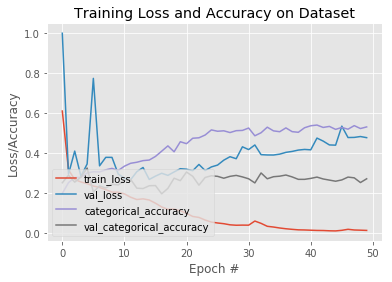

In [22]:
run_models_Small()

In [8]:
import cv2

TRAIN_CSV = "SpatialVoc2k/Training_data_"+str(0)+".csv"

with open(TRAIN_CSV, 'r') as f1:
    reader = csv.reader(f1)
    your_list = list(reader)
f1.close()
labels = []
for i in range(10):
    size = 224
    #if mode == "eval" and i ==  len(your_list):
    #    break

    #Get the labels
    x = ast.literal_eval(your_list[i][0])
    x = [n.strip() for n in x]
    print(x)
    labels.append(x)

    #Get image information and create the image
    width  = your_list[i][1]
    height  = your_list[i][2]

    bb1 = ast.literal_eval(your_list[i][3])
    bb1 = [int(n) for n in bb1]

    x1 = abs(bb1[0])
    y1 = abs(bb1[1])
    w1 = abs(bb1[2])
    h1 = abs(bb1[3])

    bb2 = ast.literal_eval(your_list[i][4])
    bb2 = [int(n) for n in bb2]

    x2 = abs(bb2[0])
    y2 = abs(bb2[1])
    w2 = abs(bb2[2])
    h2 = abs(bb2[3])

    image = Union_WB_B_Seperate(height,width,x1,y1,h1,w1,x2,y2,h2,w2)
    #print(image.shape)
    image = cv2.resize(image, (size, size))

    cv2.imshow('image',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    image = img_to_array(image)

['a_cote_de', 'au_niveau_de', 'pres_de']
['derriere', 'pres_de']
['derriere', 'a_cote_de', 'pres_de']
['sous']
['pres_de']
['derriere', 'le_long_de']
['pres_de', 'au_niveau_de']
['sur', 'contre', 'dans']
['contre', 'pres_de']
['derriere']
